In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [32]:
class Recording:
    def __init__(self, meta):
        self._id = meta._id
        self.subject_id = meta.subject_id
        self.phone_placement = meta.phone_placement
        self.recording_duration = meta.recording_duration
        self.chunk_ids = meta.chunk_ids
        self.labels = []
        self.p_ecg = []
        self.p_hr = []
        self.p_contact = []
        self.p_acc_x = []
        self.p_acc_y = []
        self.p_acc_z = []
        self.acc_x = []
        self.acc_y = []
        self.acc_z = []
        self.gyr_x = []
        self.gyr_y = []
        self.gyr_z = []
        self.gra_x = []
        self.gra_y = []
        self.gra_z = []
        self.mag_x = []
        self.mag_y = []
        self.mag_z = []
        self.att_roll = []
        self.att_pitch = []
        self.att_yaw = []
        self.delta_heading = []
        
        print(self._id)
        r_chunks = rec_chunks[self._id]
        for c in r_chunks:
            print(c._id)
        print()
        ordered_chunk_ids = {}
        
        for chunk in r_chunks:
            ordered_chunk_ids[chunk.chunk_index] = chunk
            
        for i in range(1,len(r_chunks)-1):
            chunk = chunks[ordered_chunk_ids[i]._id]
            
            assert(i == chunk.chunk_index)
            
            self.labels += chunk.labels
            self.p_ecg += chunk.p_ecg
            self.p_hr += chunk.p_hr
            self.p_contact += chunk.p_contact
            self.p_acc_x += chunk.p_acc_x
            self.p_acc_y += chunk.p_acc_y
            self.p_acc_z += chunk.p_acc_z
            self.acc_x += chunk.acc_x
            self.acc_y += chunk.acc_y
            self.acc_z += chunk.acc_z
            self.gyr_x += chunk.gyr_x
            self.gyr_y += chunk.gyr_y
            self.gyr_z += chunk.gyr_z
            self.gra_x += chunk.gra_x
            self.gra_y += chunk.gra_y
            self.gra_z += chunk.gra_z
            self.mag_x += chunk.mag_x
            self.mag_y += chunk.mag_y
            self.mag_z += chunk.mag_z
            self.att_roll += chunk.att_roll
            self.att_pitch += chunk.att_pitch
            self.att_yaw += chunk.att_yaw
            self.delta_heading += chunk.delta_heading
            
    def getIntervals(self):
        output = np.zeros((len(self.labels), 90))
        
        for i in range(len(self.labels)):
            output[i,:] = IntervalData(self, i).flatten()
        
        return output[:,:-1], output[:,-1]

In [33]:
class IntervalData:
    def __init__(self, rec, idx):
        self.label = rec.labels[idx]
        self.p_ecg = rec.p_ecg[idx*13 : idx*13 + 13]
        self.p_acc_x = rec.p_acc_x[idx*20 : idx*20 + 20]
        self.p_acc_y = rec.p_acc_y[idx*20 : idx*20 + 20]
        self.p_acc_z = rec.p_acc_z[idx*20 : idx*20 + 20]
        self.acc_x = rec.acc_x[idx]
        self.acc_y = rec.acc_y[idx]
        self.acc_z = rec.acc_z[idx]
        self.gyr_x = rec.gyr_x[idx]
        self.gyr_y = rec.gyr_y[idx]
        self.gyr_z = rec.gyr_z[idx]
        self.gra_x = rec.gra_x[idx]
        self.gra_y = rec.gra_y[idx]
        self.gra_z = rec.gra_z[idx]
        self.mag_x = rec.mag_x[idx]
        self.mag_y = rec.mag_y[idx]
        self.mag_z = rec.mag_z[idx]
        self.att_roll = rec.att_roll[idx]
        self.att_pitch = rec.att_pitch[idx]
        self.att_yaw = rec.att_yaw[idx]
        self.delta_heading = rec.delta_heading[idx]
        
    def flatten(self):
        #size = 17*1 + 13*1 + 20*3
        output = np.zeros((90))
        
        output[0:13] = np.array(self.p_ecg)
        output[13:33] = np.array(self.p_acc_x)
        output[33:53] = np.array(self.p_acc_y)
        output[53:73] = np.array(self.p_acc_z)
        output[73] = self.acc_x
        output[74] = self.acc_y
        output[75] = self.acc_z
        output[76] = self.gyr_x
        output[77] = self.gyr_y
        output[78] = self.gyr_z
        output[79] = self.gra_x
        output[80] = self.gra_y
        output[81] = self.gra_z
        output[82] = self.mag_x
        output[83] = self.mag_y
        output[84] = self.mag_z
        output[85] = self.att_roll
        output[86] = self.att_pitch
        output[87] = self.att_yaw
        output[88] = self.delta_heading
        output[89] = self.label
        
        return output
        

# Read Pickle Data

In [34]:
ddir = os.getcwd() + "/pickles/db13"
files = os.listdir(ddir)
recordings = []

for f in files:
    reader = open(ddir + "/" + f, "rb")
    rec = pickle.load(reader)
    print(rec._id)
    recordings.append(rec)

849B275E-A5B1-4A03-A374-CCFA44F34960
AD642CAB-2FE2-4B02-B7E7-0BC7695B6D04


# Parse Data Into Intervals

In [35]:
intvls = [r.getIntervals() for r in recordings]

# Sliding Windows

In [44]:
import more_itertools as mit

def window(seq, n=10):
    return np.array([list(mit.flatten(s)) for s in mit.windowed(seq, n)])

def window_1d(seq, n=10):
    return np.lib.stride_tricks.sliding_window_view(seq, window_shape = n)

In [174]:
ys = []
xs = []
num_windows = 13

for x,y in intvls:
    print(x.shape)
    print(y.shape)
    xs.append(window(x,num_windows))
    ys.append(window_1d(y,num_windows))
    print(xs[-1].shape)
    print(ys[-1].shape)
    print()

(200, 89)
(200,)
(188, 1157)
(188, 13)

(200, 89)
(200,)
(188, 1157)
(188, 13)



## Merge windows

In [175]:
num_rows = np.sum([x.shape[0] for x in xs])
print(num_rows)

376


In [176]:
xx_c = np.zeros((num_rows, num_windows*89))
yy_c = np.zeros((num_rows))

offset = 0
for i in range(len(xs)):
    assert(xs[i].shape[0] == ys[i].shape[0])
    xx_c[offset : offset+xs[i].shape[0], :] = xs[i]
    yy_c[offset : offset+xs[i].shape[0]] = [1 if s >= 1 else 0 for s in np.sum(ys[i], axis=1)]
    offset += xs[i].shape[0]

In [177]:
xx_r = np.zeros((num_rows, num_windows*89))
yy_r = np.zeros((num_rows))

offset = 0
for i in range(len(xs)):
    assert(xs[i].shape[0] == ys[i].shape[0])
    xx_r[offset : offset+xs[i].shape[0], :] = xs[i]
    yy_r[offset : offset+xs[i].shape[0]] = [1 if s >= 1 else 0 for s in np.sum(ys[i], axis=1)]
    offset += xs[i].shape[0]

In [178]:
from sklearn.model_selection import train_test_split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(xx_c, yy_c, test_size=0.2, random_state=42, shuffle=True)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(xx_r, yy_r, test_size=0.2, random_state=42, shuffle=True)

# Shift and scale

In [ ]:
new_x = np

# Linear Regression test

In [179]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [180]:
lr = LinearRegression()

### Regression

In [181]:
lr.fit(Xr_train, yr_train)

# Predict
y_pred = [1 if p >= 1 else 0 for p in lr.predict(Xr_test)]
y_actual = [1 if y >= 1 else 0 for y in yr_test]

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_actual, y_pred)))

0.4442616583193193


### Classification

In [182]:
lr.fit(Xc_train, yc_train)

# Predict
y_pred = lr.predict(Xc_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(yc_test, y_pred)))

1.1909857182453953


# SVM test

In [183]:
from sklearn import svm

### Regression

In [184]:
regr = svm.SVR()
regr.fit(Xr_train, yr_train)

y_pred = regr.predict(Xr_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(yr_test, y_pred)))

0.20053627505027072


In [185]:
y_pred = [1 if p >= 1 else 0 for p in regr.predict(Xr_test)]
y_actual = [1 if y >= 1 else 0 for y in yr_test]

print(np.sqrt(metrics.mean_squared_error(y_actual, y_pred)))

0.47295265146345866


### Classification

In [190]:
clf = svm.SVC()
clf.fit(Xc_train, yc_train)

y_pred = clf.predict(Xc_test)

print(np.sqrt(metrics.mean_squared_error(yc_test, y_pred)))
print(metrics.accuracy_score(yc_test, y_pred))

0.19867985355975656
0.9605263157894737


In [203]:
j = 4

In [204]:
x0 = Xr_test[j,:]
y0 = yr_test[j]
yp0 = regr.predict(x0.reshape(1,-1))

ecg = np.zeros((130))

offset = 0
for i in range(10):
    ecg[i*13:i*13+13] = x0[i*89:i*89 + 13]

[0.23668206]
0.0


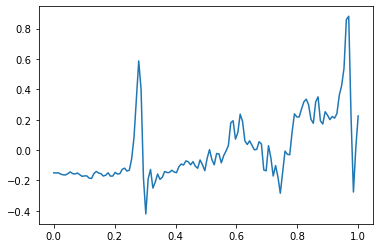

In [205]:
plt.plot(np.linspace(0,1,130), (ecg-np.mean(ecg))/np.max(np.abs(ecg)))
print(yp0)
print(y0)